 GROUP COMPONENTS:
- Tito Tamburini
- Angelo Mandara
- Enrico Grimaldi
- Claudiu Gabriel Gheorghiu
- Giuseppe Di Poce


# Fraudulent Transactions Detection

### Context
We are going to develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan.

### Content

Data Dictionary:

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

Useful packages import

In [25]:
import pandas as pd
import numpy as np
from numpy import median
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor #multi-collinearity
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

**Exploratory Data Analysis (EDA)** 

In [26]:
# Reading the csv file
data=pd.read_csv('Fraud.csv')

In [27]:
#Let's take a look to the data
data.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


In [28]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There are no missing values in our dataset but we must remember that, as already said before, "oldbalanceDest" and "newbalanceDest" have not information for customers that start with M (Merchants).

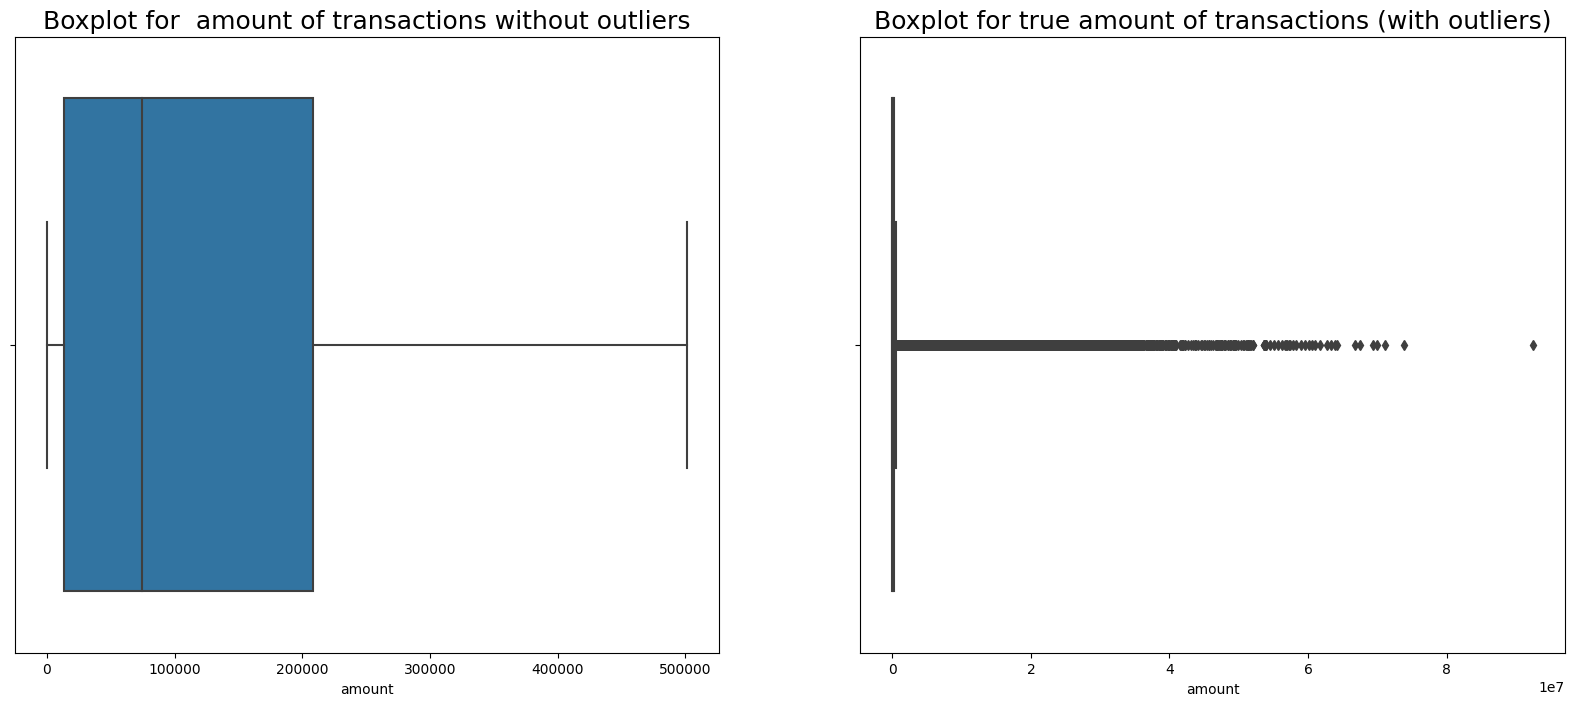

In [29]:
plt.figure(figsize=(20, 8))

one = plt.subplot(1, 2, 1)
one.set_title("Boxplot for  amount of transactions without outliers", 
             {"fontsize":18})
sns.boxplot(x=data["amount"],showfliers = False)

two = plt.subplot(1, 2, 2)
two.set_title("Boxplot for true amount of transactions (with outliers)", 
             {"fontsize":18})
sns.boxplot(x=data["amount"],showfliers = True)

plt.show()

Observing on the right the "true" **amount** is heavy the presence of outliers: the box is flat. Visually the imagine on the left tells us expicitely the distibution it's strongly asymmetric (mean > median). The most (75%) of transactions are under 208'722$, on average 179'862$, 50% < 74'872$.
In the next cell the statistics. 

In [30]:
print(data.amount.describe().to_markdown())
print("Median : " + str(median(data.amount)))

|       |           amount |
|:------|-----------------:|
| count |      6.36262e+06 |
| mean  | 179862           |
| std   | 603858           |
| min   |      0           |
| 25%   |  13389.6         |
| 50%   |  74871.9         |
| 75%   | 208721           |
| max   |      9.24455e+07 |
Median : 74871.94


Let's take a look at the number of fraud and legit transaction. Then more strictly which types are the "dangerous".

In [31]:
print("In absolute : \n" + str(data.isFraud.value_counts()))
print("In proportion : \n" + str(data.isFraud.value_counts(1)))

In absolute : 
0    6354407
1       8213
Name: isFraud, dtype: int64
In proportion : 
0    0.998709
1    0.001291
Name: isFraud, dtype: float64


In [32]:
# dataset divided by isFraud
F=data[data.isFraud==1]
NF=data[data.isFraud==0]

In [38]:
F.index  = [ x for x in range(len(F))]
NF.index  = [ x for x in range(len(NF))]

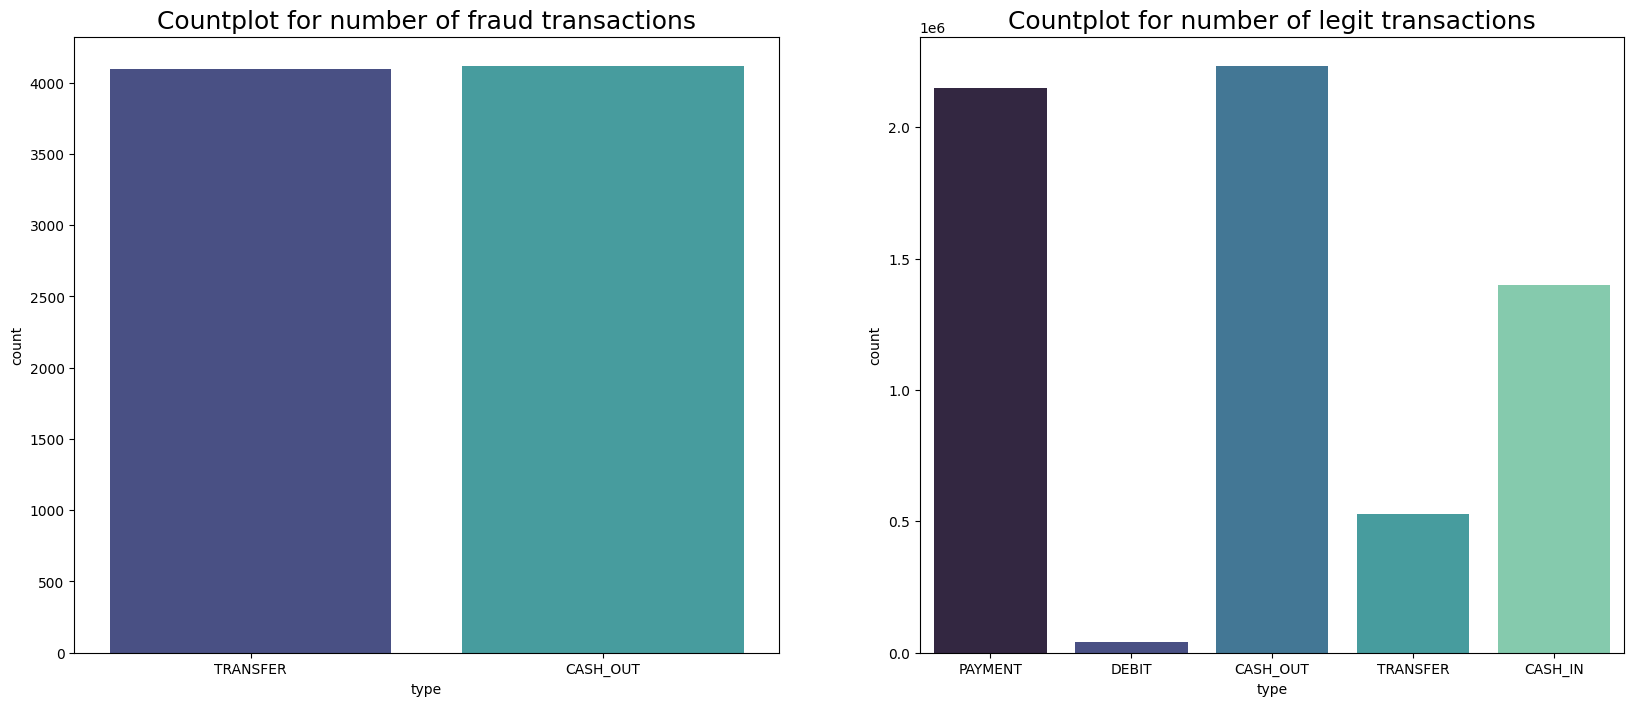

In [40]:

plt.figure(figsize=(20, 8))

one = plt.subplot(1, 2, 1)
one.set_title("Countplot for number of fraud transactions", 
             {"fontsize":18})
sns.countplot(data = F,x = F.type, palette='mako')

two = plt.subplot(1, 2, 2)
two.set_title("Countplot for number of legit transactions", 
             {"fontsize":18})
sns.countplot(data=  NF, x = NF.type, palette='mako')

plt.show()

In [41]:
print("Number of not fraud transaction per type : \n " + str(NF.type.value_counts()) + "\n")
print("Number of fraud transaction per type : \n " + str(F.type.value_counts()))

Number of not fraud transaction per type : 
 CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64

Number of fraud transaction per type : 
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


The number of fraud movements is 8213, the 0.1% of the total. They are divided between the types "CASH_OUT" and "TRANSER" and respect to the amount mostly present with small ones.

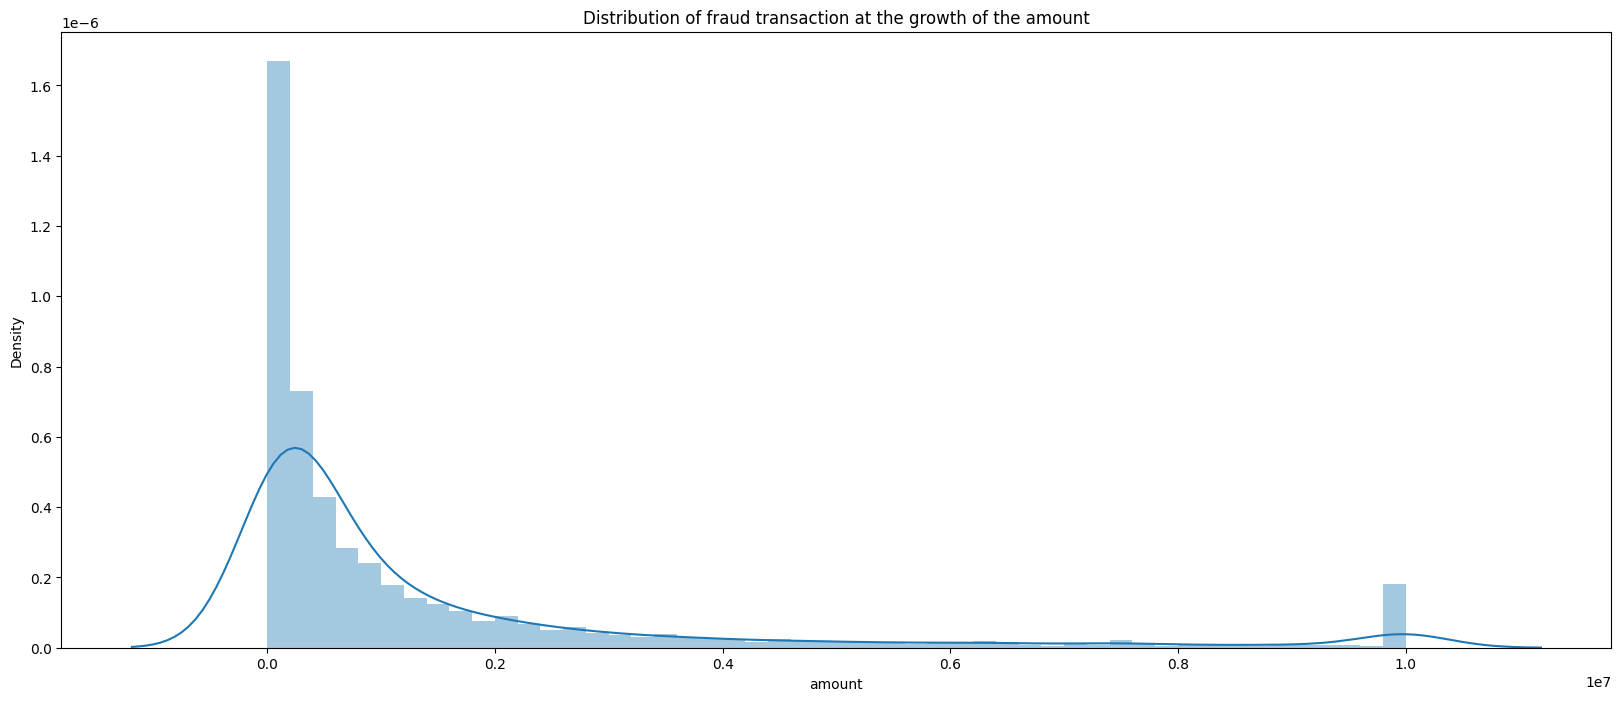

In [42]:
plt.figure(figsize=(20, 8))
sns.distplot(F['amount'])
plt.title("Distribution of fraud transaction at the growth of the amount", fontdict=None, loc='center')
plt.show()

In [43]:
print("Total Unique Values in nameOrig", data['nameOrig'].nunique())

Total Unique Values in nameOrig 6353307


In [44]:
print("Total Unique Values in nameDest", data['nameDest'].nunique())

Total Unique Values in nameDest 2722362


In [45]:
data.isFlaggedFraud.value_counts() #we will drop this column because irrilevant

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


3 categorical objects: step, nameOrig, nameDest.
### Feature engineering

In [47]:
len(data.loc[data['nameDest'].apply(lambda x: x[0]=='C')])+len(data.loc[data['nameDest'].apply(lambda x: x[0]=='M')])==len(data)
# just M and C

True

In [48]:
types = pd.get_dummies(data.type, prefix='type', drop_first=True)
#By dropping one of the one-hot encoded columns from each categorical feature, we ensure there are no "reference" columns and the remaining columns become linearly independent.
types.head()

,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,1,0,0,0
4,0,0,1,0


In [7]:
data['nameOrig'] = le.fit_transform(data['nameOrig'])
data['nameDest'] = le.fit_transform(data['nameDest'])

#class sklearn.preprocessing.LabelEncoder: encodes labels with value between 0 and n_classes-1 (remove one dummy variable column, known as the reference, to avoid "dummy trap" of redundancy)

In [8]:
data[['nameOrig', 'nameDest']]

,nameOrig,nameDest
0,757869,1662094
1,2188998,1733924
2,1002156,439685
3,5828262,391696
4,3445981,828919
...,...,...
6362615,5651847,505863
6362616,1737278,260949
6362617,533958,108224
6362618,2252932,319713


In [9]:
#putting all together
data = pd.concat([data, types], axis=1)
data = data.drop('type', axis=1)
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,1,0
2,1,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,1
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,1,0


Let's take an important step to get the basis to our model: how do the variables behave respect to each other?

### Correlation

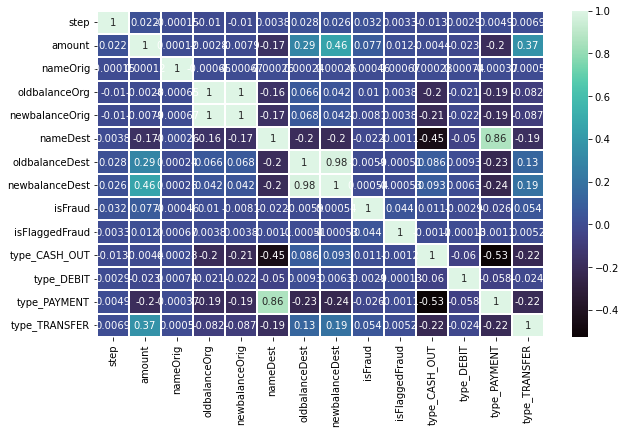

In [220]:
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), cmap='mako', linewidth=0.2, annot=True)
plt.show()

The existence of collinearity inflates the variances of the parameter estimates, and consequently incorrect inferences about relationships between explanatory and response variables. Examining the correlation matrix may be helpful to detect multicollinearity, but not sufficient. Much better diagnostics are produced by linear regression with **VIF**.

### Multi-Collinearity analysis

In statistics, **multicollinearity** (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a degree of accuracy. The coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data. Multicollinearity does not reduce the predictive power or reliability of the model as a whole; it only affects calculations regarding individual predictors. That is, a multivariate regression model with collinear predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others.

"No multicollinearity" refers to the absence of perfect multicollinearity, which is an exact (non-stochastic) linear relation among the predictors. In such a case, the design matrix $X$ has less than full rank, and therefore the moment matrix $X^{T}X$ cannot be inverted. Under these circumstances, for a general linear model $y=X\beta +\epsilon$ , the ordinary least squares estimator  $\hat{\beta }_{OLS}=(X^{T}X)^{-1}X^{T}$ does not exist.

A formal detection-tolerance for the variance inflation factor (VIF) for multicollinearity is given by:

**tolerance** $= 1-R_{j}^{2}$      ,              **VIF** $ =\frac{1}{tolerance}$

where $R_{j}^{2}$ is the "coefficient of determination" of a regression (proportion of the variation in the dependent variable that is predictable from the independent variables)  of explanator j on all the other explanators. A tolerance of less than 0.20 or 0.10 and/or a VIF of 5 or 10 and above indicates a multicollinearity problem.

In [5]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [10]:
data_without_text=pd.DataFrame({"step":data.step,
                                "amount":data.amount,
                                "nameOrig":data.nameOrig,
                                "nameDest":data.nameDest,
                               "oldbalanceOrg":data.oldbalanceOrg,
                               "newbalanceOrig":data.newbalanceOrig,
                               "oldbalanceDest":data.oldbalanceDest,
                               "newbalanceDest":data.newbalanceDest,
                               "isFraud":data.isFraud,
                               "isFlaggedFraud":data.isFlaggedFraud,
                               "type_CASH_OUT":data.type_CASH_OUT,
                               "type_DEBIT":data.type_DEBIT,
                               "type_PAYMENT":data.type_PAYMENT,
                               "type_TRANSFER":data.type_TRANSFER})
vif_data = pd.DataFrame()
vif_data["feature"] = data_without_text.columns
  
vif_data["VIF"] = [variance_inflation_factor(data_without_text.values, i)
                          for i in range(len(data_without_text.columns))]
  
print(vif_data.to_markdown())

|    | feature        |       VIF |
|---:|:---------------|----------:|
|  0 | step           |   3.23864 |
|  1 | amount         |   4.30982 |
|  2 | nameOrig       |   3.266   |
|  3 | nameDest       |   7.29414 |
|  4 | oldbalanceOrg  | 622.175   |
|  5 | newbalanceOrig | 632.216   |
|  6 | oldbalanceDest |  73.8897  |
|  7 | newbalanceDest |  85.7511  |
|  8 | isFraud        |   1.20711 |
|  9 | isFlaggedFraud |   1.00262 |
| 10 | type_CASH_OUT  |   2.48706 |
| 11 | type_DEBIT     |   1.02691 |
| 12 | type_PAYMENT   |   7.49372 |
| 13 | type_TRANSFER  |   1.53711 |


Most research papers consider a VIF (Variance Inflation Factor) > 10 as an indicator of multicollinearity. 

https://quantifyinghealth.com/vif-threshold/

Dangerous variables:

1. oldbalanceorg and newbalanceorig
2. oldbalanceDest and newbalanceDest

Prevention:

For moderate to large sample sizes, the approach to drop one of the correlated variables was established entirely satisfactory to reduce multicollinearity. 

https://www.tandfonline.com/doi/abs/10.1080/09720502.2010.10700699?journalCode=tjim20#:~:text=Multicollinearity%20is%20a%20statistical%20phenomenon%20in%20which%20two%20or%20more,relationships%20among%20the%20explanatory%20variables.

1. drop oldbalnceorg and newbalaceorig and and add the difference of column in the data set.
2. same for oldbalanceDest and newbalanceDest.

In [50]:
old_balance=data["oldbalanceOrg"]  # initial balance before the transaction
new_balance=data["newbalanceOrig"] # new balance after the transaction
bal_change=[] #if balace decrease: 1 else 0
for i in range(len(old_balance)):
  diff=new_balance[i]-old_balance[i]
  if diff>0:
      bal_change.append(1)
  else:
      bal_change.append(0)

In [63]:
print("Balances changed: " + str(bal_change.count(0))+ "\n" + "Balances not changed : " + str(bal_change.count(1)))

Balances changed: 4963367
Balances not changed : 1399253


In [ ]:
dest_old=data["oldbalanceDest"] # initial balance recipient before the transaction
dest_new=data["newbalanceDest"] # new balance recipient after the transaction
dest_bal_change=[]
dest_bal=[]
for i in range(len(dest_old)):
    diff=dest_new[i]-dest_old[i]
    if diff>0:
        dest_bal_change.append(1)
        dest_bal.append(abs(diff))
    else:
        dest_bal_change.append(0)
        dest_bal.append(abs(diff))

In [53]:
data["source_bal_change"]=bal_change
data["destination"]=dest_bal
data["dest_bal_change"]=dest_bal_change

In [54]:
data.drop(["oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","isFlaggedFraud"],axis=1,inplace=True)

In [55]:
data.head()

,step,type,amount,nameOrig,nameDest,isFraud,source_bal_change,destination,dest_bal_change
0,1,PAYMENT,9839.64,C1231006815,M1979787155,0,0,0.0,1
1,1,PAYMENT,1864.28,C1666544295,M2044282225,0,0,0.0,1
2,1,TRANSFER,181.00,C1305486145,C553264065,1,0,0.0,1
3,1,CASH_OUT,181.00,C840083671,C38997010,1,0,21182.0,1
4,1,PAYMENT,11668.14,C2048537720,M1230701703,0,0,0.0,1


In [56]:
len(data.loc[data.source_bal_change==1])

1399253

#### Choose way to process type column

1. Drop 'PAYMENT' 'CASH_IN' 'DEBIT'
2. Create n-1 columns for n types

In [60]:
not_fraud =  data.loc[data.type != 'CASH_OUT'].loc[data.type!='TRANSFER']

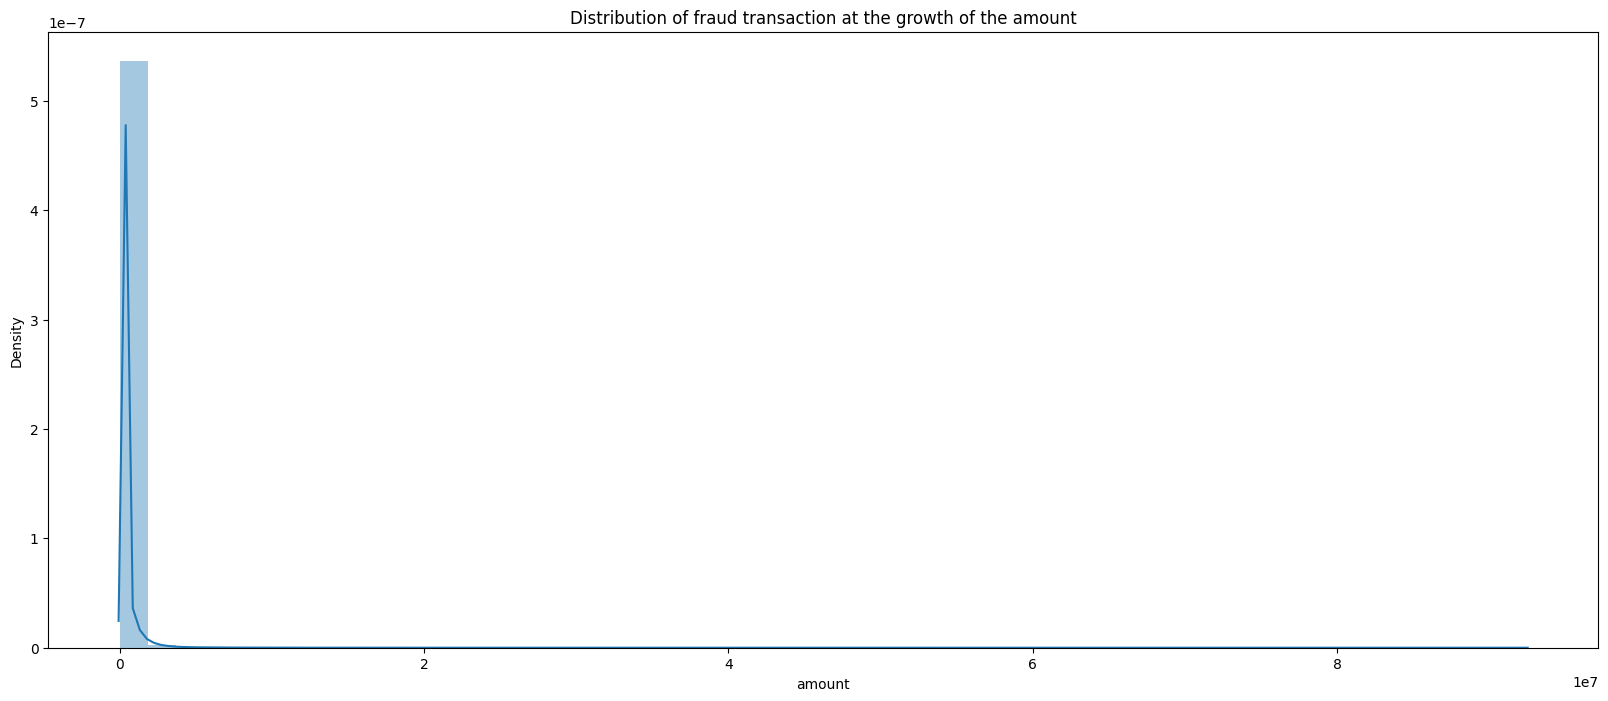

In [62]:
plt.figure(figsize=(20, 8))
sns.distplot(data['amount'])
plt.title("Distribution of fraud transaction at the growth of the amount", fontdict=None, loc='center')
plt.show()

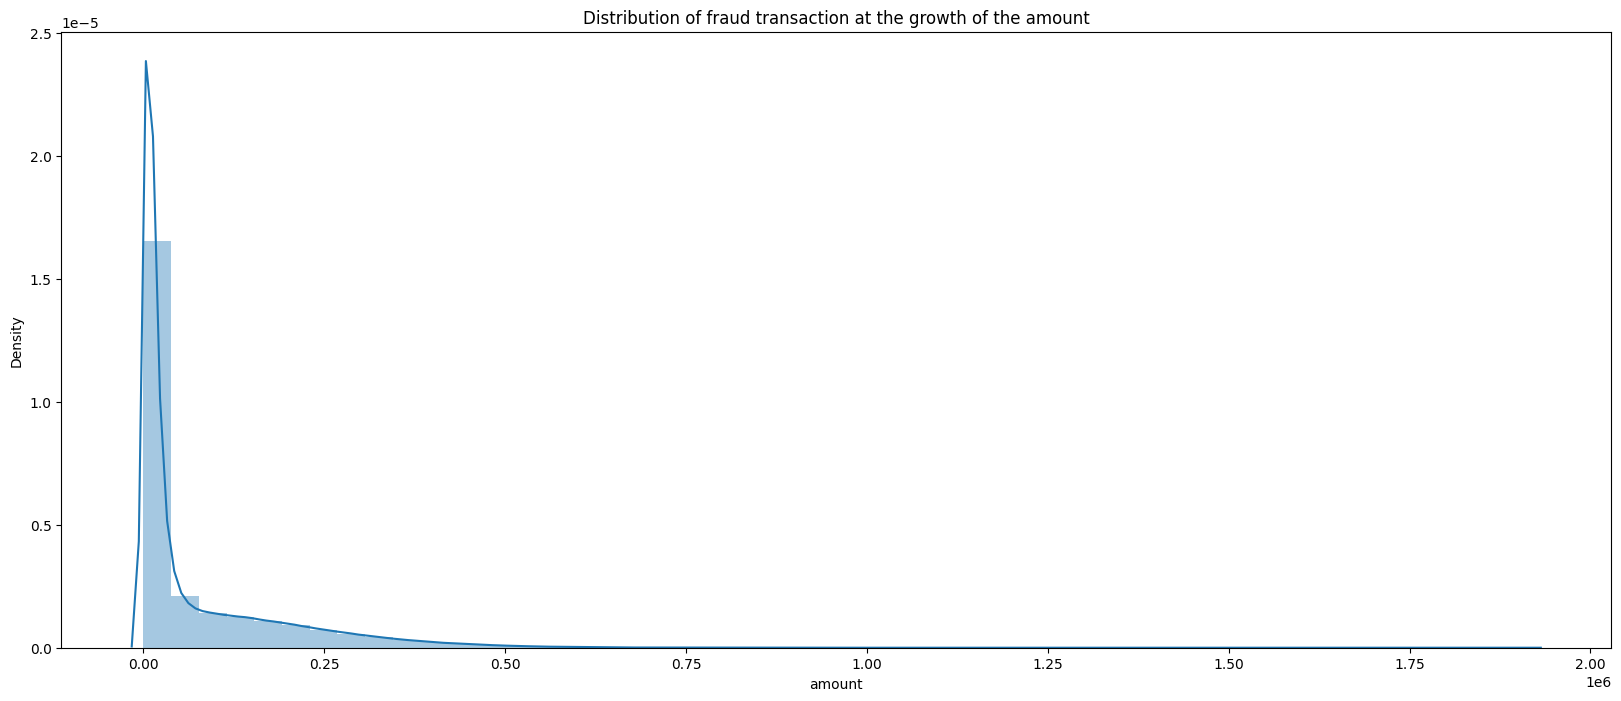

In [61]:
plt.figure(figsize=(20, 8))
sns.distplot(not_fraud['amount'])
plt.title("Distribution of fraud transaction at the growth of the amount", fontdict=None, loc='center')
plt.show()

drop rows where type = PAYMENT or CASH_IN or DEBIT, because there are no fraudolent transactions of these types.

In [65]:
data =  data.loc[data['type'] != 'PAYMENT'].loc[data['type'] != 'CASH_IN'].loc[data['type'] != 'DEBIT']

In [69]:
data.head()

,step,type,amount,nameOrig,nameDest,isFraud,source_bal_change,destination,dest_bal_change
2,1,TRANSFER,181.00,C1305486145,C553264065,1,0,0.00,1
3,1,CASH_OUT,181.00,C840083671,C38997010,1,0,21182.00,1
15,1,CASH_OUT,229133.94,C905080434,C476402209,0,0,46430.44,0
19,1,TRANSFER,215310.30,C1670993182,C1100439041,0,0,22425.00,1
24,1,TRANSFER,311685.89,C1984094095,C932583850,0,0,2712905.89,0


In [70]:
data['type']  =  pd.get_dummies(data.type,prefix='type',drop_first=True)

# type == 1 if TRANSFER
# type == 0 if CASH_OUT

In [73]:
data['nameOrig'] = le.fit_transform(data['nameOrig'])
data['nameDest'] = le.fit_transform(data['nameDest'])

In [74]:
data.head()

,step,type,amount,nameOrig,nameDest,isFraud,source_bal_change,destination,dest_bal_change
2,1,1,181.00,436008,391672,1,0,0.00,1
3,1,0,181.00,2539295,348886,1,0,21182.00,1
15,1,0,229133.94,2632251,371535,0,0,46430.44,0
19,1,1,215310.30,959849,26498,0,0,22425.00,1
24,1,1,311685.89,1408914,491969,0,0,2712905.89,0


In [68]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'nameDest', 'isFraud',
       'source_bal_change', 'destination', 'dest_bal_change'],
      dtype='object')

In [75]:


data_without_text=pd.DataFrame({"step":data.step,
                                "amount":data.amount,
                                "nameOrig":data.nameOrig,
                                "nameDest":data.nameDest,
                               "isFraud":data.isFraud,
                               "type":data.type,
                               "source_bal_change": data.source_bal_change,
                               "destination" : data.destination,
                               "dest_bal_change": data.dest_bal_change
                               })
vif_data = pd.DataFrame()
vif_data["feature"] = data_without_text.columns
  
vif_data["VIF"] = [variance_inflation_factor(data_without_text.values, i)
                          for i in range(len(data_without_text.columns))]
  
print(vif_data.to_markdown())

|    | feature           |     VIF |
|---:|:------------------|--------:|
|  0 | step              | 2.83761 |
|  1 | amount            | 4.97713 |
|  2 | nameOrig          | 2.83528 |
|  3 | nameDest          | 2.83256 |
|  4 | isFraud           | 1.0619  |
|  5 | type              | 1.3678  |
|  6 | source_bal_change | 1.00001 |
|  7 | destination       | 4.59659 |
|  8 | dest_bal_change   | 1.0651  |


|    | feature           |     VIF |
|---:|:------------------|--------:|
|  0 | step              | 2.83761 |
|  1 | amount            | 4.97713 |
|  2 | nameOrig          | 2.83528 |
|  3 | nameDest          | 2.83256 |
|  4 | isFraud           | 1.0619  |
|  5 | type              | 1.3678  |
|  6 | source_bal_change | 1.00001 |
|  7 | destination       | 4.59659 |
|  8 | dest_bal_change   | 1.0651  |

In [76]:

import pickle

with open('data.pickle', 'wb') as f:
    pickle.dump(data, f)
    
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)


## Prediction model

In [ ]:
#Resampling of isFraud to balance the dataset

In [ ]:
#!pip install -U --pre pycaret

In [78]:
from pycaret.classification import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

KeyError: 'storage_options_versionadded'

In [19]:
data_train, data_test = train_test_split(data, random_state =69 , test_size = 0.3)

# train_test_split() function: The train_test_split() method is used to split our data into train and test sets. 
# First, we need to divide our data into features (X) and labels (y). The dataframe gets divided into X_train, X_test, y_train, and y_test. 
# X_train and y_train sets are used for training and fitting the model

In [20]:
# init setup
setup_data = setup(data = data_train, target = 'isFraud', 
                session_id=69, data_split_stratify=True, remove_multicollinearity=True, remove_outliers=True, fix_imbalance=True, use_gpu=True)


# pycaret.classification.setup() :  initializes the training environment and creates the transformation pipeline

# session_id: int
# Controls the randomness of experiment. This can be used for later reproducibility of the entire experiment

# data_split_stratify: bool or list
# Controls stratification during ‘train_test_split’. When set to True, will stratify by target column.

# remove_multicollinearity: bool
# Features with the inter-correlations higher than the defined threshold (multicollinearity_threshold: default = 0.9) are removed. When two features are highly correlated with each other,
# the feature that is less correlated with the target variable is removed. Only considers numeric features.

# remove_outliers: bool
# When set to True, outliers from the training data are removed using the Singular Value Decomposition

# fix_imbalance: bool
# When training dataset has unequal distribution of target class it can be balanced using this parameter. => our case with is Fraud 0 
# When set to True, SMOTE (Synthetic Minority Over-sampling Technique) is applied by default to create synthetic datapoints for minority class.

# use_gpu: bool or str
# When set to True, it will use GPU for training with algorithms that support it, and fall back to CPU if they are unavailable.

,Description,Value
0,Session id,69
1,Target,isFraud
2,Target type,Binary
3,Original data shape,"(4453834, 12)"
4,Transformed data shape,"(7255903, 12)"
5,Transformed train set shape,"(5919752, 12)"
6,Transformed test set shape,"(1336151, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [21]:
# model training and selection
best = compare_models()
best

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:28:11
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,SVM - Linear Kernel


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9982,0.8108,0.6229,0.3795,0.4704,0.4696,0.4847,107.4700
lr,Logistic Regression,0.6144,0.8753,0.8707,0.0029,0.0057,0.0032,0.0356,46.5910
nb,Naive Bayes,0.4408,0.8398,0.9368,0.0021,0.0043,0.0017,0.0272,12.8690


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [10]:
#analyze best model
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# predict on new data
predictions=predict_model(best,data=data_test)